In [15]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import networkx as nx
from itertools import combinations
from tqdm import tqdm
import pycountry
from countryinfo import CountryInfo
import pycountry
from countryinfo import CountryInfo
from tqdm import tqdm
from Countrydetails import country


In [16]:
path = '/Users/g_private/Library/CloudStorage/OneDrive-Personal/Universität Zürich/FS25/Complex Newtworks Yas/data/co-attention.csv'
df=pd.read_csv(path)
df=df.dropna()

df['countries_mentioned_list']=df['countries_mentioned'].apply(lambda x: x.split(','))
df['affiliations_list']=df['affiliations'].apply(lambda x: x.split(','))
df['Mention_number']=df['countries_mentioned_list'].apply(lambda x: len(x))

df['countries_mentioned_list'] = df['countries_mentioned_list'].apply(
    lambda lst: [c.strip().title()           # remove spaces, standard capitalisation
                 .replace('P.R. China', 'China')
                 .replace('Pr China', 'China')
                 .replace('People’s Republic Of China', 'China')
                 .replace('Cn', 'China')
                 for c in lst]
)
df['affiliations_list'] = df['affiliations_list'].apply(
    lambda lst: [c.strip().title()           # remove spaces, standard capitalisation
                 .replace('P.R. China', 'China')
                 .replace('Pr China', 'China')
                 .replace('People’s Republic Of China', 'China')
                 .replace('Cn', 'China')
                 for c in lst])

# flatten with respect to to the aggregated_value column
df = df.loc[df.index.repeat(df['aggregated_value'])].reset_index(drop= True)

df['affiliations_list'] = df['affiliations_list'] \
    .apply(lambda codes: [c.upper() for c in codes])

# List of columns to remove
cols_to_drop = [
    'countries_mentioned',
    'affiliations',
    'aggregated_value',
    #'affiliations_list',
    'Mention_number'
]

# Option 1: create a new DataFrame without those columns
df= df.drop(columns=cols_to_drop)

df['countries_mentioned_list'] = df['countries_mentioned_list'] \
    .apply(lambda codes: [c.upper() for c in codes])
# remove entries with only 1 country mentioned
df = df[df['countries_mentioned_list'].apply(len) > 1]

df['countries_mentioned_list'] = df['countries_mentioned_list'].apply(lambda lst:[c for c in lst if len(c) < 4]) 

df = df[df['countries_mentioned_list'].apply(len) > 1]

Graph: 247 nodes, 17554 edges


  0%|          | 0/50 [00:00<?, ?it/s]/Users/g_private/anaconda3/envs/complex_networks/lib/python3.10/site-packages/sklearn/metrics/cluster/_supervised.py:49: UserWarning:

The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.

/Users/g_private/anaconda3/envs/complex_networks/lib/python3.10/site-packages/sklearn/metrics/cluster/_supervised.py:50: UserWarning:

The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.

/Users/g_private/anaconda3/envs/complex_networks/lib/python3.10/site-packages/sklearn/metrics/cluster/_supervised.py:49: UserWarning:

The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.

/Users/g_private/anaconda3/envs/complex_networks/lib/python3.10/site-packages/sklearn/metrics/cluster/_supervised

[<Axes: xlabel='$log_{10}(t)$', ylabel='$log_{10}(t^\\prime)$'>,
 <Axes: xlabel='$log_{10}(t)$', ylabel='NVI'>,
 <Axes: ylabel='Stability'>,
 <Axes: ylabel='# clusters'>,
 <Axes: xlabel='$log_{10}(t)$', ylabel='Block NVI'>]

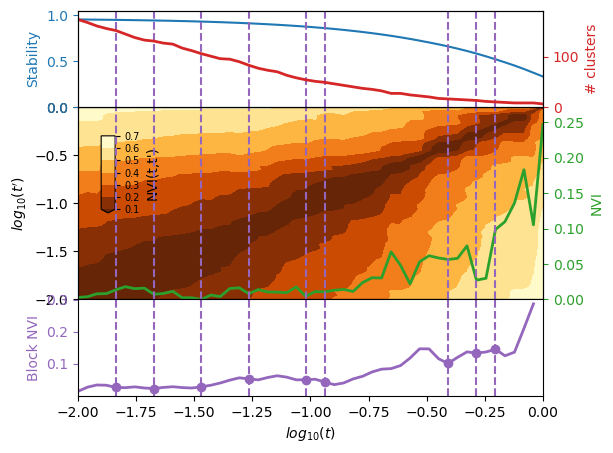

In [17]:
import itertools
from collections import Counter
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import scipy.sparse as sp
import pygenstability as pgs
from pygenstability import plotting

# ──────────────────────────────────────────────
# 1) Build co-mention network from your df
# ──────────────────────────────────────────────
def build_comention_graph(df, list_col='countries_mentioned_list', min_weight=0.01, fractional=True):
    edge_counts = Counter()
    for countries in df[list_col]:
        uniq = sorted(set(countries))  # remove duplicates
        k = len(uniq)
        if k < 2:
            continue
        weight_per_edge = 1 / (k * (k - 1) / 2) if fractional else 1
        for u, v in itertools.combinations(uniq, 2):
            edge_counts[(u, v)] += weight_per_edge
    
    G = nx.Graph()
    for (u, v), w in edge_counts.items():
        if w >= min_weight:
            G.add_edge(u, v, weight=w)
    return G

G = build_comention_graph(df, min_weight=0)  # adjust min_weight if needed
print(f"Graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

# ──────────────────────────────────────────────
# 2) Convert to adjacency for PyGenStability
# ──────────────────────────────────────────────
node_order = list(G.nodes())
A = nx.to_numpy_array(G, nodelist=node_order, weight='weight')

# ──────────────────────────────────────────────
# 3) Run multiscale community detection
# ──────────────────────────────────────────────
results = pgs.run(
    sp.csr_matrix(A),
    method="leiden",
    n_scale=50,
    n_tries=100,
    min_scale=-2,        # adjust if you want fewer/more communities
    max_scale=0,
    constructor="linearized",
    n_workers=16
)

# Identify robust scales
results = pgs.identify_optimal_scales(results, kernel_size=4, window_size=2)
plotting.plot_scan(results)


In [23]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from collections import Counter, defaultdict

def build_sankey_from_pygen(
    results,
    node_order,
    part_indices=None,
    topk_per_level=None,   # e.g. 10 → keep top-10 largest communities per level
    min_comm_size=1,       # drop communities smaller than this (after relabel)
    show_counts=True,      # include "n=..." in node labels
    palette=None           # custom list of colors (will be cycled)
):
    """
    Build a Sankey figure that shows how countries flow between PyGen communities
    across multiple scales (levels). Flow values = number of countries in the overlap.
    """
    # 1) pick partitions (levels)
    community_id = results["community_id"]             # list of arrays, each len = |nodes|
    if part_indices is None:
        if "selected_partitions" in results and len(results["selected_partitions"]) > 0:
            part_indices = list(results["selected_partitions"])
        else:
            # fallback: take evenly spaced 6 levels across the scan
            m = len(community_id)
            k = min(6, m)
            part_indices = sorted(set(np.linspace(0, m-1, k, dtype=int).tolist()))

    levels = []
    for pi in part_indices:
        lab = np.asarray(community_id[pi]).copy()
        # relabel communities to contiguous ints sorted by size for nicer legends
        counts = Counter(lab)
        # optionally drop very small communities
        keep = {cid for cid, sz in counts.items() if sz >= min_comm_size}
        lab = np.array([x if x in keep else -1 for x in lab])  # -1 → "Other"
        counts = Counter(lab)
        # sort by size (largest first), ensure -1 ("Other") last if present
        uniq = [cid for cid, _ in sorted(counts.items(), key=lambda kv: (-kv[1], kv[0]))]
        if -1 in uniq:
            uniq = [u for u in uniq if u != -1] + [-1]

        # optionally keep only top-k and fold the rest into "Other" (-1)
        if topk_per_level is not None and topk_per_level > 0:
            keep_set = set(uniq[:topk_per_level])
            lab = np.array([x if x in keep_set else -1 for x in lab])
            counts = Counter(lab)
            uniq = [cid for cid, _ in sorted(counts.items(), key=lambda kv: (-kv[1], kv[0]))]
            if -1 in uniq:
                uniq = [u for u in uniq if u != -1] + [-1]

        # map original ids → 0..L-1 (with "Other" last)
        remap = {cid: i for i, cid in enumerate(uniq)}
        relabeled = np.array([remap[x] for x in lab])

        levels.append({
            "part_idx": pi,
            "labels": relabeled,     # ints 0..K-1
            "orig_ids": uniq,        # original PyGen ids (with -1 meaning "Other")
            "sizes": [Counter(relabeled)[i] for i in range(len(uniq))]
        })

    # 2) create global list of sink/source nodes for Sankey: (level, comm_id)
    node_index = {}
    node_labels = []
    node_colors = []

    # palette for colors
    if palette is None:
        # 20 qualitative colors cycled; feel free to swap
        palette = [
            "#4e79a7","#f28e2b","#e15759","#76b7b2","#59a14f",
            "#edc949","#af7aa1","#ff9da7","#9c755f","#bab0ab",
            "#1b9e77","#d95f02","#7570b3","#e7298a","#66a61e",
            "#e6ab02","#a6761d","#666666","#8dd3c7","#ffffb3"
        ]

    def color_for(level_idx, comm_idx):
        # deterministically pick a color by level + community index
        return palette[(level_idx * 7 + comm_idx) % len(palette)]

    # build nodes
    for li, L in enumerate(levels):
        for ci, sz in enumerate(L["sizes"]):
            idx = len(node_labels)
            node_index[(li, ci)] = idx
            # label text
            base = f"L{li+1} C{ci}"
            if L["orig_ids"][ci] == -1:
                base = f"L{li+1} Other"
            if show_counts:
                base += f" (n={sz})"
            node_labels.append(base)
            node_colors.append(color_for(li, ci))

    # 3) build links between consecutive levels via crosstab overlaps
    sources, targets, values, link_colors, link_labels = [], [], [], [], []
    for li in range(len(levels) - 1):
        a = levels[li]["labels"]
        b = levels[li+1]["labels"]
        # overlaps: counts for each (a_comm, b_comm)
        df = pd.DataFrame({"a": a, "b": b})
        cross = pd.crosstab(df["a"], df["b"])
        for a_comm, row in cross.iterrows():
            for b_comm, val in row.items():
                if val <= 0:
                    continue
                s = node_index[(li, int(a_comm))]
                t = node_index[(li+1, int(b_comm))]
                sources.append(s)
                targets.append(t)
                values.append(int(val))
                # fade of the target color
                rgb = node_colors[t].lstrip("#")
                r, g, b = tuple(int(rgb[i:i+2], 16) for i in (0, 2, 4))
                link_colors.append(f"rgba({r},{g},{b},0.25)")
                link_labels.append(f"{node_labels[s]} → {node_labels[t]}: n={int(val)}")

    # 4) build figure
    fig = go.Figure(data=[go.Sankey(
        arrangement="snap",
        node=dict(
            pad=20,
            thickness=18,
            label=node_labels,
            color=node_colors
        ),
        link=dict(
            source=sources,
            target=targets,
            value=values,
            color=link_colors,
            label=link_labels,
            hovertemplate="%{label}<extra></extra>"
        )
    )])

    # title showing which partitions used
    scale_str = ", ".join([str(L["part_idx"]) for L in levels])
    fig.update_layout(
        title=f"PyGen community flows across scales (partitions: {scale_str})",
        font=dict(size=12),
        height=max(500, 140 * len(levels))  # taller if many levels
    )
    return fig


# ===== Example call =====
# Use all robust scales (what you called “the different levels”)
part_indices = results.get("selected_partitions", None)

# Build and show Sankey; keep small communities grouped into 'Other' and
# (optionally) keep only the top 10 communities per level to avoid clutter.
fig = build_sankey_from_pygen(
    results,
    node_order,
    part_indices=part_indices,
    topk_per_level=10,    # set to None to include all
    min_comm_size=2,      # group singletons into "Other"
    show_counts=True
)
#fig.show()


In [31]:
# e.g. if results["community_id"] has length m
m = len(results["community_id"])

# pick partitions starting from index 5 up to the end
part_indices = list(range(5, 10))   # or whatever range you want
robust = results["selected_partitions"]
part_indices = robust[-5:]   # last 5 robust partitions

fig = build_sankey_from_pygen(
    results,
    node_order,
    part_indices=part_indices,
    topk_per_level=10,
    min_comm_size=2,
    show_counts=True
)


In [35]:
# ===== Example call =====
# Use robust scales (or define part_indices manually, e.g. start at layer 5)

robust = results["selected_partitions"]
part_indices = robust[-5:]   # last 5 robust partitions

# Build and show Sankey
fig = build_sankey_from_pygen(
    results,
    node_order,
    part_indices=part_indices,
    topk_per_level=10,   # set to None to include all
    min_comm_size=1,     # group singletons into "Other"
    show_counts=True
)

# To display:
# fig.show()


In [36]:
import plotly.io as pio
pio.renderers.default = "browser"   # or "vscode" if you're in VS Code

fig.show()
